In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append(r'C:\Users\acostamendoza\projects\Grid-orientation-project\src')
from GridMetrics import GridScorer, circle_mask, get_even_odd_times, GridParameters, create_new_result_dir, load_grid_metrics_from_pickle
import json
%load_ext autoreload
%autoreload 2

# Set default parameters for matplotlib
plt.rcParams.update({
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14, 
    'axes.titlesize': 16,
    'legend.fontsize': 12,
})

In [17]:
rat = 'r1'
mod = '2'
fig_directory  = r'C:\Users\acostamendoza\Box\grid-cell-project\review-borders-vs-variability'

In [3]:
G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)
    
with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
    cell_trial_dict = json.load(f)

Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists


# Get between variability

In [4]:
 def return_accepted(cell_trial_dict):
    
    accepted = []
    
    for cell in cell_trial_dict:
        none_trials = 0
        for trial in cell_trial_dict[cell]:
            if cell_trial_dict[cell][trial]['spacing_odd'] is None:
                none_trials += 1
            elif cell_trial_dict[cell][trial]['spacing_even'] is None:
                none_trials += 1
                
        if none_trials <= 5:
            accepted.append(cell)
    
    return accepted

C:\Users\acostamendoza\projects\Grid-orientation-project\src\GridMetrics.py:226: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


(-1.0, 1.0)

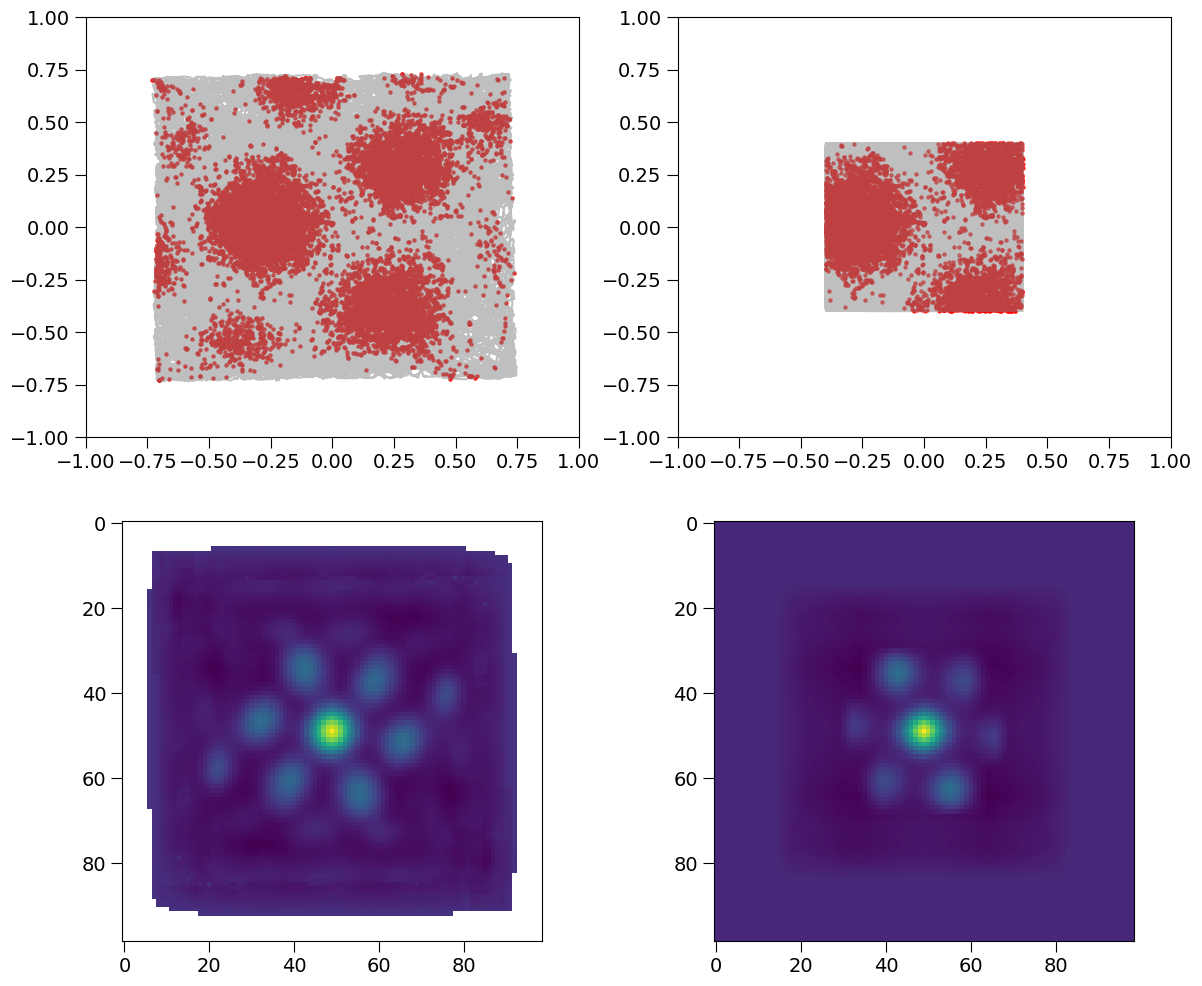

In [5]:
cell = 146
threshold = 0.4

x = G.x
y = G.y
spikes = G.spikes

sac = G.Scorer.calculate_sac(cell)

plt.subplots(2, 2, figsize=(14, 12))

ax = plt.subplot(2, 2, 1)
ax.plot(x, y, color='grey', alpha=0.5)
ax.scatter(x[spikes[cell] != 0], y[spikes[cell] != 0], color='red', alpha=0.8, s=5)
ax.set_ylim([-1, 1])
ax.set_xlim([-1, 1])

masked_sac = np.ma.masked_where(sac == 0, sac)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad(color='white')

ax = plt.subplot(2, 2, 3)
ax.imshow(masked_sac)

# Filtering 

mask = (np.abs(x) <= threshold) & (np.abs(y) <= threshold)
x_filtered = x[mask]
y_filtered = y[mask]

spikes_filtered = {neuron: spikes[neuron][mask] for neuron in spikes}

G_filtered = GridScorer(x_filtered, y_filtered, spikes_filtered)

sac_filtered = G_filtered.calculate_sac(cell)

ax = plt.subplot(2, 2, 4)
ax.imshow(sac_filtered)

ax = plt.subplot(2, 2, 2)
ax.plot(x_filtered, y_filtered, color='grey', alpha=0.5)
ax.scatter(x_filtered[spikes_filtered[cell] != 0], y_filtered[spikes_filtered[cell] != 0], color='red', alpha=0.7, s=5)
ax.set_ylim([-1, 1])
ax.set_xlim([-1, 1])

In [7]:
# filter coordinates by the threshold
def filter_coordinates(G, threshold):
    
    x = G.x
    y = G.y
    spikes = G.spikes
    
    # for mask to be True both have to be lower tha nthe threshold
    mask = (np.abs(y) <= threshold) & (np.abs(x) <= threshold)
    x_filtered = x[mask]
    y_filtered = y[mask]

    spikes_filtered = {neuron: spikes[neuron][mask] for neuron in spikes}

    G_filtered = GridScorer(x_filtered, y_filtered, spikes_filtered)
    
    return G_filtered

def get_mean_and_std_of_filtered_coordinates(G_filtered, accepted):
    
    orientations = []
    spacings = []
    
    for cell in accepted:
        sac = G_filtered.calculate_sac(int(cell))
        spacing, orientation , _ = G.get_spacing_orientation_and_score(sac)

        if orientation is None:
            continue

        orientations.append(orientation)
        spacings.append(spacing)

    orientation_mean = np.mean(orientations)
    orientation_std = np.std(orientations)
    
    spacing_mean = np.mean(spacings)
    spacing_std = np.std(spacings)
    
    return orientation_mean, spacing_mean, orientation_std, spacing_std

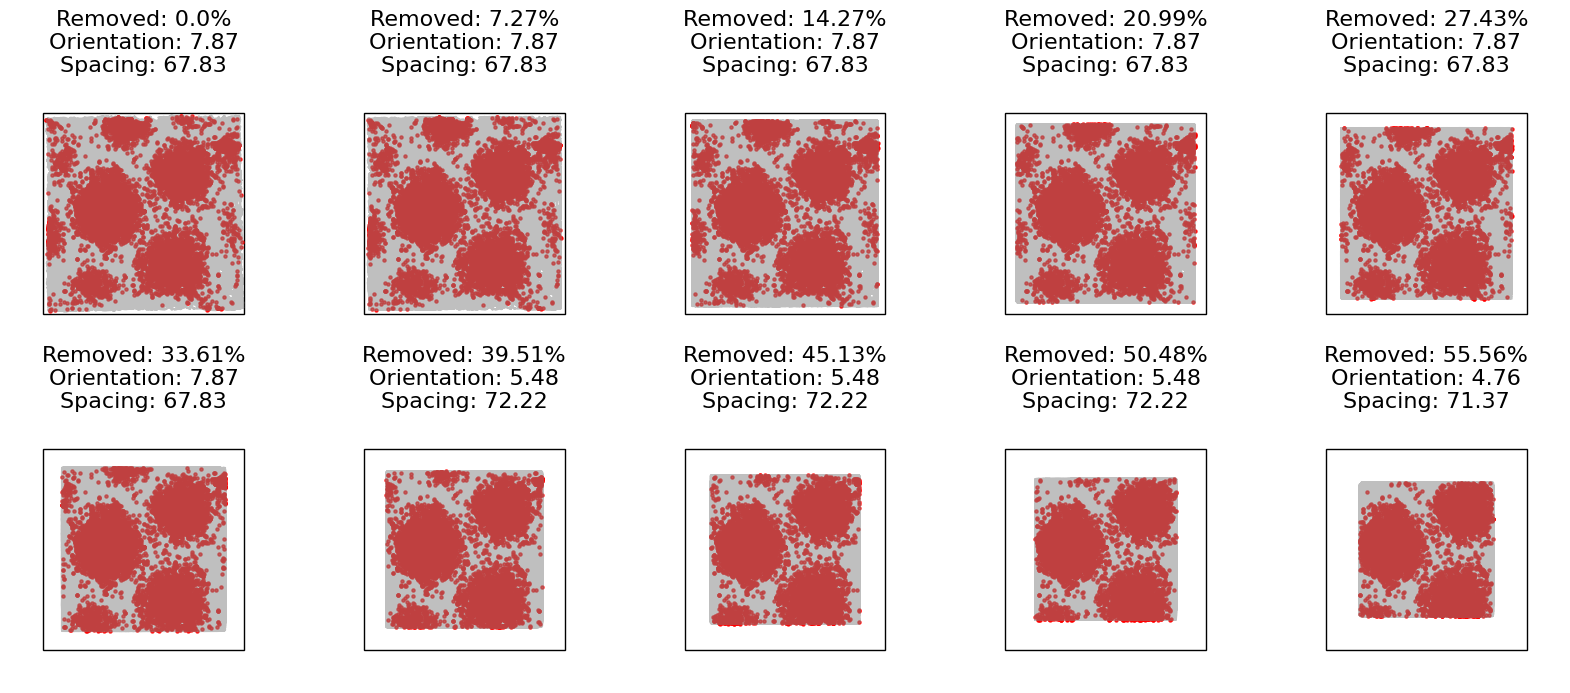

In [11]:
import matplotlib.patches as patches

cell = 146
thresholds = np.linspace(0.75, 0.5, 10)

total_area = 1.5*1.5

orientations = []
spacings = []

plt.subplots(2, 5, figsize=(20, 8))

for threshold in thresholds:
    
    G_filtered = filter_coordinates(G, threshold)
    sac = G_filtered.calculate_sac(cell)
    
    threshold_area = (2*threshold)**2
    proportion = 1 - threshold_area/total_area
    
    spacing, orientation, score = G.get_spacing_orientation_and_score(sac)
    
    orientations.append(orientation)
    spacings.append(spacing)
    
    x = G_filtered._x
    y = G_filtered._y
    spikes = G_filtered._spikes
    
    ax = plt.subplot(2, 5, np.where(thresholds == threshold)[0][0] + 1)
    ax.plot(x, y, color='grey', alpha=0.5)
    # draw a square that goes from 0.8 to -0.8 in x and y
    square = patches.Rectangle((-0.75, -0.75), 1.5, 1.5, linewidth=1, edgecolor='black', facecolor='none')
    # Add the square to the plot
    ax.add_patch(square)
    
    ax.scatter(x[spikes[cell] != 0], y[spikes[cell] != 0], color='red', alpha=0.8, s=5)
    ax.set_title('Removed: ' + str(round(100 * proportion, 2)) + '%' + '\n' + 'Orientation: ' + str(np.round(orientation, 2)) + '\n' + 'Spacing: ' + str(np.round(spacing, 2)))
    ax.set_ylim([-1, 1])
    ax.set_xlim([-1, 1])
    # set ticks and ticks labels and everything axis off
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # axis square
    ax.set_aspect('equal')
    

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

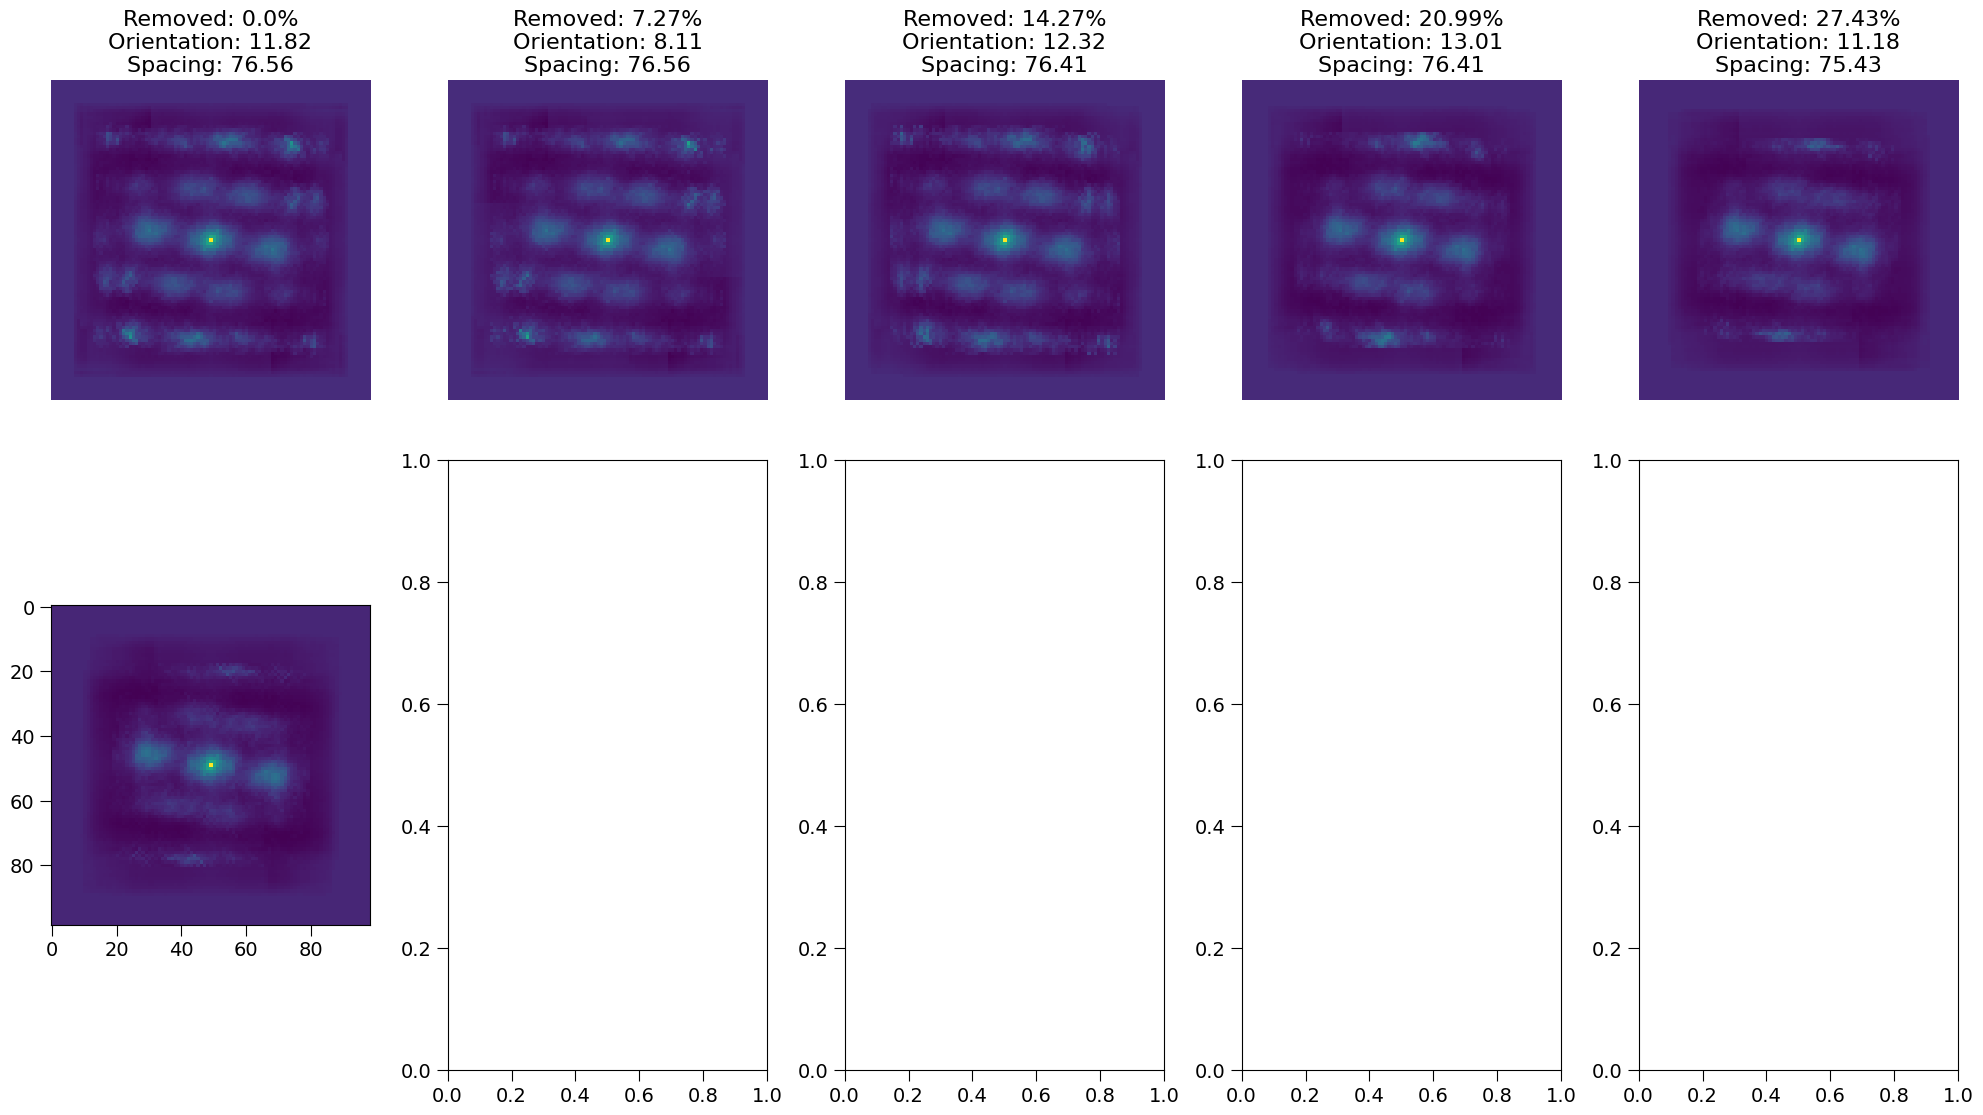

In [37]:
import matplotlib.patches as patches

cell = 146
thresholds = np.linspace(.75, .5, 10)

total_area = 1.5*1.5

orientations = []
spacings = []

plt.subplots(2, 5, figsize=(20, 12))

for threshold in thresholds:
    
    G_filtered = filter_coordinates(G, threshold)
    sac = G_filtered.calculate_sac(cell)
    
    threshold_area = (2*threshold)**2
    proportion = 1 - threshold_area/total_area
    
    spacing, orientation, score = G.get_spacing_orientation_and_score(sac)
    
    orientations.append(orientation)
    spacings.append(spacing)
    
    ax = plt.subplot(2, 5, np.where(thresholds == threshold)[0][0] + 1)
    ax.imshow(sac)
    # draw a square that goes from 0.8 to -0.8 in x and y
    
    ax.set_title('Removed: ' + str(round(100 * proportion, 2)) + '%' + '\n' + 'Orientation: ' + str(np.round(orientation, 2)) + '\n' + 'Spacing: ' + str(np.round(spacing, 2)))
    # set ticks and ticks labels and everything axis off
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # axis square
    ax.set_aspect('equal')
    plt.tight_layout()

In [13]:
thresholds = np.linspace(0.5, 0.75, 50)
accepted = return_accepted(cell_trial_dict)

orientations_mean = []
orientations_std = []
spacings_mean = []
spacings_std = []

for threshold in thresholds:
    
    G_filtered = filter_coordinates(G, threshold)
    orientation_mean, spacing_mean, orientation_std, spacing_std = get_mean_and_std_of_filtered_coordinates(G_filtered, accepted)
    
    orientations_mean.append(orientation_mean)
    orientations_std.append(orientation_std)
    
    spacings_mean.append(spacing_mean)
    spacings_std.append(spacing_std)

19
20
20
21
28
31
32
33
33
34
34
33
51
45
44
47
46
47
50
50
64
64
66
66
68
66
67
67
79
77
80
80
80
80
79
79
82
82
82
82
82
82
82
82
82
82
82
82
82
82


Rat q Mod 1
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\q1 already exists
48
49
51
50
50
50
51
51
51
51
51
51
51
51
51
51
51
51
51
51
Rat q Mod 2
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\q2 already exists
4
6
6
6
6
6
7
7
7
6
6
7
7
7
7
7
7
7
7
7
Rat r1 Mod 1
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r11 already exists
71
82
80
81
82
82
87
87
87
88
88
92
92
92
92
92
92
92
92
92
Rat r1 Mod 2
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists
49
65
67
68
68
67
78
81
80
79
79
82
82
82
82
82
82
82
82
82
Rat r1 Mod 3
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r13 already exists
3
6
6
6
6
6
6
7
7
7
7
8
8
8
8
8
8
8
8
8
Rat s Mod 1
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\s1 already exists
46
50
49
50
52
52
55
55
55
55
55
55
55
55
55
55
55
55
55
55
Rat r2 Mod 1
Directory C:\Users\acostamendoz

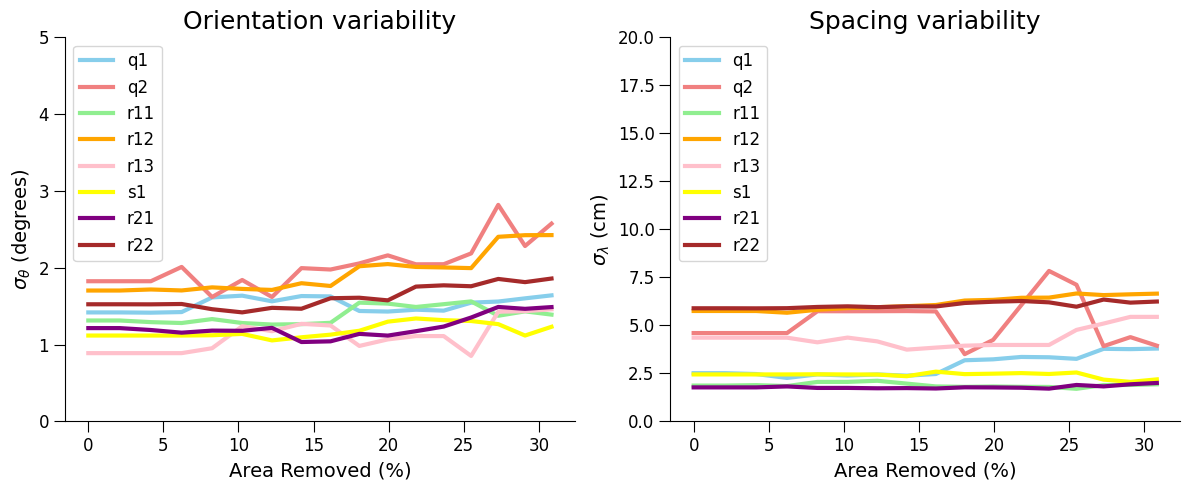

In [36]:
# plot the std dev as function of the threshold
# plt.scatter(grid_score_session, delta_orientation_within_sessions, color = 'lightgrey', s= 30, edgecolor='grey')
# multiply every value of width by a hundred
rats = ['q', 'q', 'r1', 'r1', 'r1', 's', 'r2', 'r2']
mods = ['1', '2', '1', '2', '3', '1', '1', '2']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'pink', 'yellow', 'purple', 'brown', 'black']
i = 0

thresholds = np.linspace(0.6, 0.75, 20)
thresholds_pctg = (1 - (2*thresholds)**2/total_area)*100

session_std_orientation = []
session_std_spacing = []
    
for rat, mod in zip(rats, mods):
    print('Rat ' + rat + ' Mod ' + mod)
    
    color = colors[i]
    i += 1
    G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)

    with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
        cell_trial_dict = json.load(f)
        
    accepted = return_accepted(cell_trial_dict)
    
    orientations_std = []
    spacings_std = []
    
    for threshold in thresholds:
        
        G_filtered = filter_coordinates(G, threshold)
        _, _, orientation_std, spacing_std = get_mean_and_std_of_filtered_coordinates(G_filtered, accepted)
        
        orientations_std.append(orientation_std)
        spacings_std.append(spacing_std)
    
    session_std_spacing.append(spacings_std)
    session_std_orientation.append(orientations_std)
        
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    fig.suptitle('Rat ' + rat + ' Module ' + mod, fontsize = 18)
    ax[0].plot(np.flip(thresholds_pctg), np.flip(orientations_std), color=colors[i], linewidth=3)
    ax[0].set_title(r'Orientation variability', fontsize=18)
    ax[0].set_ylabel(r'$\sigma_{\theta}$ (degrees)', fontsize=14)
    ax[0].set_xlabel(r'Area Removed (%)', fontsize=14)
    ax[0].set_ylim([0, 5])

    ax[1].plot(np.flip(thresholds_pctg), np.flip(spacings_std), color=colors[i], linewidth=3)
    ax[1].set_title('Spacing variability', fontsize=18)
    ax[1].set_ylabel(r'$\sigma_{\lambda}$ (cm)', fontsize=14)
    ax[1].set_xlabel(r'Area Removed (%)', fontsize=14)
    ax[1].set_ylim([0, 20])

    # remove splines
    for axx in ax:
        axx.spines['top'].set_visible(False)
        axx.spines['right'].set_visible(False)
        axx.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.savefig(fig_directory + '/rat-' + rat + '-mod-' + mod + '.png')
    plt.savefig(fig_directory + '/rat-' + rat + '-mod-' + mod + '.svg')
    plt.close()
    
## plot the std dev as function of the threshold for all sessions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

delta_std_orientation = []
delta_std_spacing = []

for i in range(len(rats)):
    
    delta_std_orientation.append(np.array(session_std_orientation[i]) - np.array(session_std_orientation[i][0]))
    delta_std_spacing.append(np.array(session_std_spacing[i]) - np.array(session_std_spacing[i][0]))

for i in range(len(rats)):
    
        ax[0].plot(np.flip(thresholds_pctg[3:]), np.flip(session_std_orientation[i][3:]), color=colors[i], linewidth=3)
        ax[0].set_title(r'Orientation variability', fontsize=18)
        ax[0].set_ylabel(r'$\sigma_{\theta}$ (degrees)', fontsize=14)
        ax[0].set_xlabel(r'Area Removed (%)', fontsize=14)
        ax[0].set_ylim([0, 5])
    
        ax[1].plot(np.flip(thresholds_pctg[3:]), np.flip(session_std_spacing[i][3:]), color=colors[i], linewidth=3)
        ax[1].set_title('Spacing variability', fontsize=18)
        ax[1].set_ylabel(r'$\sigma_{\lambda}$ (cm)', fontsize=14)
        ax[1].set_xlabel(r'Area Removed (%)', fontsize=14)
        ax[1].set_ylim([0, 20])
        
        # add legend

ax[0].legend(['q1', 'q2', 'r11', 'r12', 'r13', 's1', 'r21', 'r22'], loc='upper left')
ax[1].legend(['q1', 'q2', 'r11', 'r12', 'r13', 's1', 'r21', 'r22'], loc='upper left')
    
# # remove splines
for axx in ax:
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.tick_params(axis='both', which='major', labelsize=12)  
    
plt.tight_layout()
plt.savefig(fig_directory + '/all-rats-mods.png')
plt.savefig(fig_directory + '/all-rats-mods.svg')

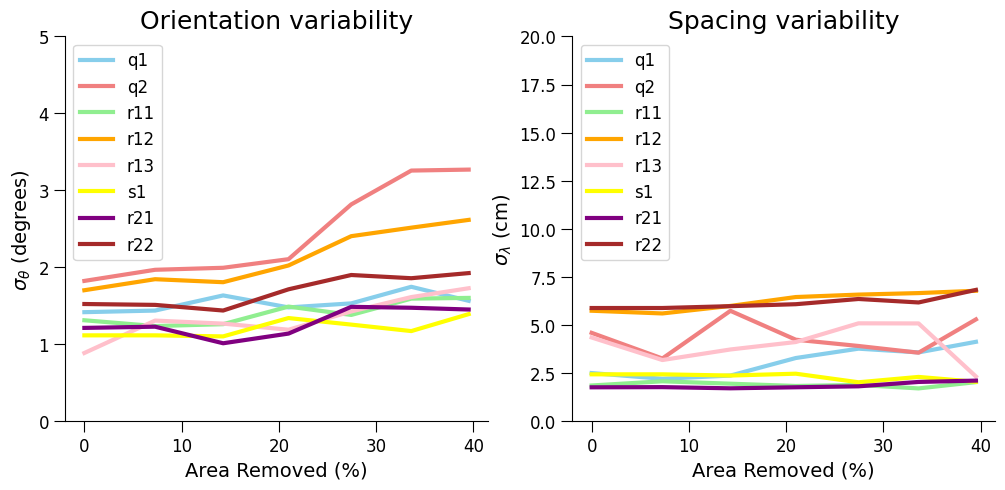

In [35]:
# plot the std dev as function of the threshold for all sessions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

delta_std_orientation = []
delta_std_spacing = []

for i in range(len(rats)):
    
    delta_std_orientation.append(np.array(session_std_orientation[i]) - np.array(session_std_orientation[i][0]))
    delta_std_spacing.append(np.array(session_std_spacing[i]) - np.array(session_std_spacing[i][0]))

for i in range(len(rats)):
    
        ax[0].plot(np.flip(thresholds_pctg[3:]), np.flip(session_std_orientation[i][3:]), color=colors[i], linewidth=3)
        ax[0].set_title(r'Orientation variability', fontsize=18)
        ax[0].set_ylabel(r'$\sigma_{\theta}$ (degrees)', fontsize=14)
        ax[0].set_xlabel(r'Area Removed (%)', fontsize=14)
        ax[0].set_ylim([0, 5])
    
        ax[1].plot(np.flip(thresholds_pctg[3:]), np.flip(session_std_spacing[i][3:]), color=colors[i], linewidth=3)
        ax[1].set_title('Spacing variability', fontsize=18)
        ax[1].set_ylabel(r'$\sigma_{\lambda}$ (cm)', fontsize=14)
        ax[1].set_xlabel(r'Area Removed (%)', fontsize=14)
        ax[1].set_ylim([0, 20])
        
        # add legend

ax[0].legend(['q1', 'q2', 'r11', 'r12', 'r13', 's1', 'r21', 'r22'], loc='upper left')
ax[1].legend(['q1', 'q2', 'r11', 'r12', 'r13', 's1', 'r21', 'r22'], loc='upper left')
    
# # remove splines
for axx in ax:
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.tick_params(axis='both', which='major', labelsize=12)

ValueError: operands could not be broadcast together with shapes (50,) (0,) 

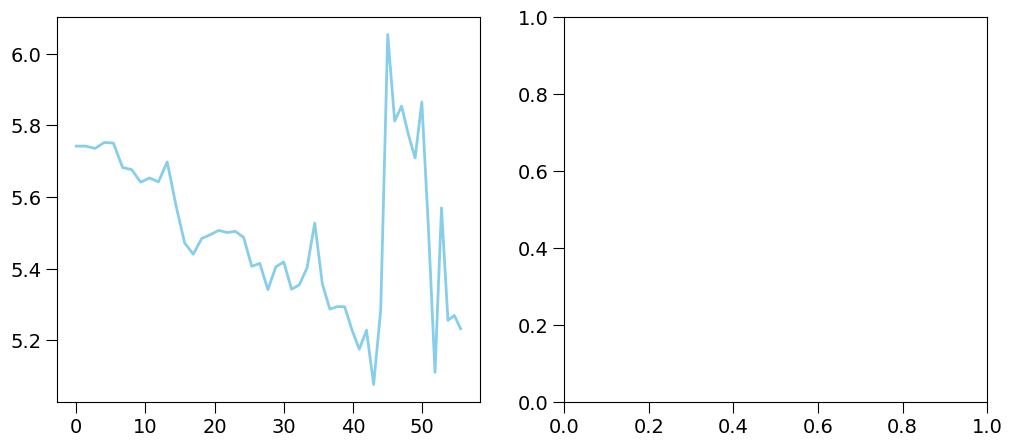

In [19]:
# transform thresholds to proportion removed
thresholds = np.linspace(0.5, 0.75, 10)
thresholds = (1 - (2 * thresholds) ** 2 / total_area) * 100

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(thresholds, orientations_mean, color='skyblue', linewidth=2)

ax[0].fill_between(thresholds, np.array(orientations_mean) - np.array(orientations_std), np.array(orientations_mean) + np.array(orientations_std), alpha=0.5, color='skyblue')
ax[0].set_title('Orientation', fontsize=18)
# ax[0].set_ylim([2, 9])

ax[0].set_ylabel(r'$\theta$ (degrees)', fontsize=14)
ax[0].set_xlabel(r'Area removed (%)', fontsize=14)
ax[0].set_ylim([2, 9])
# remove splines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].plot(thresholds, spacings_mean, color='coral', linewidth=2)
ax[1].fill_between(thresholds, np.array(spacings_mean) - np.array(spacings_std), np.array(spacings_mean) + np.array(spacings_std), alpha=0.5, color='coral')
ax[1].set_title('Spacing', fontsize=18)
ax[1].set_ylabel(r'$\lambda$ (cm)', fontsize=14)
ax[1].set_xlabel(r'Area removed (%)', fontsize=14)
ax[1].set_ylim([70, 100])
# remove splines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)